# Gaussian process regression with posterior distributions

The joint distribution $p(\mathbf{t},\mathbf{z})$ of labelled observations $\mathbf{t}$ and kernel latent parameters $\mathbf{z}$ for homoscsedastic Gaussian process regression can be split into the log conditional likelihood

\begin{equation}
\ln p(\mathbf{t}|\mathbf{z}) = -\frac{1}{2}\ln |\mathbf{C}| - \frac{1}{2}\mathbf{t}^{\mathrm{T}}\mathbf{C}^{-1}\mathbf{t} - \frac{1}{2}\mathrm{order}(\mathbf{C})\ln (2\pi)
\end{equation}

and latent variable priors $p(\mathbf{z})$. For a radial basis function kernel with homoscedastic white noise, the kernel 

\begin{equation}
k(\mathbf{x}_i,\mathbf{x}_j) = (z_1)^2 \exp\left(-\frac{1}{2}|\mathbf{x}_i-\mathbf{x}_j|^2 (z_2)^{-2}\right) + \delta_i^j (\Delta + (z_3)^2)
\end{equation}

depends on latent variables $\mathbf{z}=(z_1,z_2,z_3)\in\mathbb{R}^3$, where $\delta_i^j$ is the Kronecker delta and $\Delta\sim 10^{-6}$ is a small correction to introduce a higher degree of numerical stability when inverting the positive semi-definite matrix $\mathbf{C}_{ij} = k(\mathbf{x}_i,\mathbf{x}_j)$. 

### Inferring posterior distributions

The task at hand is to infer the posterior distribution

\begin{equation}
p(\mathbf{z}|\mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{z})p(\mathbf{z})}{\int p(\mathbf{t}|\mathbf{z}^{\prime})p(\mathbf{z}^{\prime})\mathrm{d}\mathbf{z}^{\prime}} ,
\end{equation}

which we achieve through approximating that

\begin{equation}
q(\mathbf{z}|\boldsymbol{\lambda}) \approx p(\mathbf{z}|\mathbf{t}),
\end{equation}

where $\boldsymbol{\lambda}$ are distribution parameters for $q(\mathbf{z}|\boldsymbol{\lambda})$. We can infer $p(\mathbf{z}|\mathbf{t})$ by minimizing the dissimilarity between $q(\mathbf{z}|\boldsymbol{\lambda})$ and $p(\mathbf{z}|\mathbf{t})$ with respect to $\boldsymbol{\lambda}$, which is equivalent to maximising a quantity known as the Evidence Lower BOund

\begin{equation}
\mathrm{ELBO}(\boldsymbol{\lambda}) = \int q(\mathbf{z}|\boldsymbol{\lambda}) \Big(\ln p(\mathbf{t}|\mathbf{z}) + \ln p(\mathbf{z}) - q(\mathbf{z}|\boldsymbol{\lambda})\Big)\mathrm{d}\mathbf{z}.
\end{equation}

### Normal latent variable priors

To maximize the $\mathrm{ELBO}(\boldsymbol{\lambda})$, we need to evaluate its derivative with respect to $\boldsymbol{\lambda}$. We can take advantage of analytical expressions for some of the expectations above, by taking the mean-field approximation for $q(\mathbf{z}|\boldsymbol{\lambda})$:

\begin{equation}
q(\mathbf{z}|\boldsymbol{\lambda}) = \prod_{k=1}^3q(z_k|\boldsymbol{\lambda}_k).
\end{equation}

The $\mathrm{ELBO}(\boldsymbol{\lambda})$ can then be rephrased as

\begin{equation}
\mathrm{ELBO}(\boldsymbol{\lambda}) = \int q(\mathbf{z}|\boldsymbol{\lambda}) \ln p(\mathbf{t} | \mathbf{z})\mathrm{d}\mathbf{z} - \sum_{k=1}^3 \mathrm{KL}\big(q(z_k|\boldsymbol{\lambda}_k)||p(z_k)\big),
\end{equation}

where the Kullbach-Leibler divergence 

\begin{equation}
\mathrm{KL}\big(q(z_k|\boldsymbol{\lambda}_k)||p(z_k)\big) = -\frac{1}{2}\left(1+2\ln \sigma_k - (\mu_k)^2 - (\sigma_k)^2\right)
\end{equation}

has a closed form when $q(z_k|\boldsymbol{\lambda}_k)=\mathcal{N}(z_k|\mu_k,(\sigma_k)^2)$ and $p(z_k)=\mathcal{N}(z_k|0,1)$ [[1]](https://arxiv.org/pdf/1312.6114.pdf).

### Reparameterization gradient variational inference

The only task remaining before we can maximize the $\mathrm{ELBO}(\boldsymbol{\lambda})$ is to evaluate the gradient of the expected log-conditional term. For this, we reparameterize $z_k=\mu_k+\sigma_k\epsilon_k$, where $\epsilon_k\sim \mathcal{N}(\epsilon_k|0,1)$ and consider the expression 

\begin{equation}
\nabla_{\boldsymbol{\lambda}} \int q(\mathbf{z}|\boldsymbol{\lambda}) p(\mathbf{t}|\mathbf{z}) \mathrm{d}\mathbf{z}  \approx \frac{1}{N}\sum_{i=1}^N \nabla_{\boldsymbol{\lambda}} \ln p(\mathbf{t}|\boldsymbol{\lambda})
\end{equation}

from reparameterization gradient variational inference [[1]](ttps://arxiv.org/pdf/1312.6114.pdf). Here, indices $i$ represent $N$ samples of $\epsilon_i$, forming a stochastic estimate for the $\mathrm{ELBO}(\boldsymbol{\lambda})$. 

### Updating the posterior distribution

The $\mathrm{ELBO}(\boldsymbol{\lambda})$ can now be maximized through stochastic gradient ascent of latent variable approximate posterior distribution parameters $\boldsymbol{\lambda}$:

\begin{equation}
(\lambda_i)_{\mathrm{iter\hspace{1mm} n +1}} = (\lambda_i)_{\mathrm{iter\hspace{1mm} n }} + \alpha \nabla_{\lambda_i} \mathrm{ELBO}(\boldsymbol{\lambda}),
\end{equation}

where we use the learning rate

\begin{equation}
\alpha = \frac{\alpha_0}{1+(\delta) (\mathrm{n})} .
\end{equation}

The decay rate $\delta$ and initial learning rate $\alpha_0$ are problem-dependent hyperparameters that can be adjusted by ensuring that the $\mathrm{ELBO}(\boldsymbol{\lambda})$ increases monotonically (in a stochastic fashion).


[[1]](https://arxiv.org/pdf/1312.6114.pdf) D. Kingma, M. Welling, *Auto-Encoding Variational Bayes*, arXiv: 1312.6114, (2014).


# Example

In [1]:
from bayesgpr.gpr import GPR
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

### Generate a univariate set of toy data

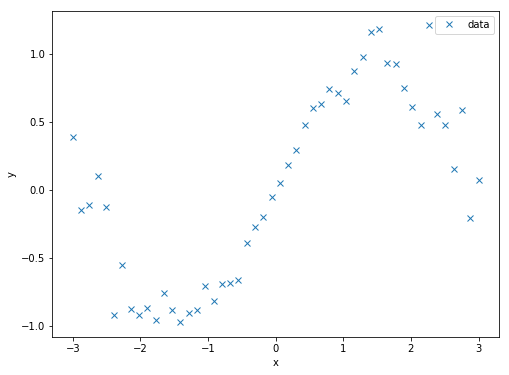

In [2]:
# observed data
x = np.linspace(-3,3,50)

# noisy observed labels
t = np.sin(x) + np.random.normal(size=x.shape)*abs(x)*1e-1


# illustrate data
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(x,t,marker="x",linestyle="none",label="data")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()
plt.show()

Figure 1: *Toy data for illustrate maximization of the Evidence Lower BOund.*

### Inferrence 

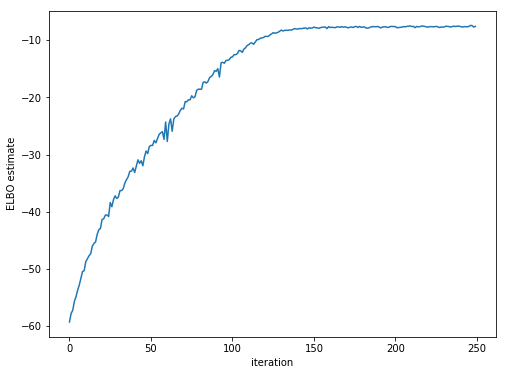

In [12]:
model = GPR(Nsample=500,maxiter=250,lr=5e-4,decay_rate=1e-1,alpha=1e-3)

model.fit(x,t)


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))

ax.plot(np.arange(len(model.loss)),model.loss)
ax.set_xlabel("iteration")
ax.set_ylabel("ELBO estimate")
plt.show()

Figure 2: *The Evidence Lower BOund increases monotonically (within the context of a stochastic gradient ascent) as latent variable distribution parameters are successively updated.*

### Prediction

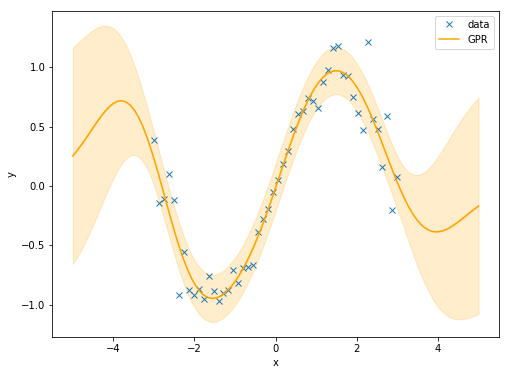

In [15]:
# test data
xtest = np.linspace(-5,5,100)


fig,_ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))

# get expected value and standard deviation of posterior predictive dist.
mean,std = model.predict(xtest)

_ax.plot(x,t,marker="x",linestyle="none",label="data")
_ax.plot(xtest,mean,color="orange",label="GPR")
_ax.fill_between(xtest,mean-std,mean,color="orange",alpha=0.2)
_ax.fill_between(xtest,mean,mean+std,color="orange",alpha=0.2)
_ax.set_xlabel("x")
_ax.set_ylabel("y")
_ax.legend()

plt.show()

Figure 3: *The original toy data (x) and first (solid line) and squar-root of the second (shaded area) moments of the posterior predictive distribution.*